# Demonstrate use of new databases

Melissa made this demo for Midori.

It is based on a NB by Rob in his decat_jupyter repo.
 - https://github.com/rknop/decat_jupyter

Import packages.

In [1]:
import sys
import os
import pathlib
import pandas
import numpy
import getpass
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

Connect to the database.

In [2]:
dbuser = input("DB User: ")

DB User:  decat_ro


In [3]:
dbpasswd = getpass.getpass("DB Password: ")

DB Password:  ········


In [4]:
db = psycopg2.connect( dbname="decat", host="decatdb.lbl.gov", port=5432, user=dbuser, password=dbpasswd,
                       cursor_factory=psycopg2.extras.RealDictCursor )

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor()

Optional: view the table schemas.

In [ ]:
# tables = ['versiontags','exposures','subtractions','images',\
#           'objects','objectrbs','objectdatas','objectdata_versiontag','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

## Demo query

Find all of the objects (detections in difference images) with a real/bogus score > 0.6 in the ELAIS fields.

> `ELAIS-E1 00:31:30 -43:00:35` <br> 
`ELAIS-E2 00:38:00 -43:59:53`

Approximate range in decimal degrees:
> RA, 0.0 to 20 <br>
Dec, -40 to -50


### New: processing versions

**Explainer text from Rob:**
Things in the database are tagged with versions.
This is because we might redo something, or we might try different subtraction algorithms.
This might change in the future, but, at the moment everything that's in the database should be tagged with the "latest" tag, which means it was the last thing saved to the database.

So for now Midori and Melissa will use database elements tagged as "latest"

In [5]:
tag = "latest"   # Eventually we'll probably want to use "default"
db.rollback()
q = ( "SELECT id,tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']

In [6]:
print(tagid)

1


### Retrieve a sample of objects in the ELAIS field.

Just FYI, to use "JOIN" alone is the same as "INNER JOIN".

This query, how the tables are joined and the spatial constraints, are effectively the same as the first query in Thomas's notebook "AGNpercentages.ipynb", though I'm being more specific about the RA Dec constraints, and I'm including the proposal IDs from 2022, not just 2021.

For this example, retrieve RA, Dec, apparent magnitude and its error, the real/bogus score, the filter and the MJD of the observation, and the proposal ID.
Just so we can make a couple of simple demo plots.

However, it only retrieves 37846 objects, and that does not make sense... there should be many more.

In [7]:
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, i.filter, i.meanmjd, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "
     "AND rbs.rb > 0.6 "
     "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
     "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
     "LIMIT 10000000" )
cursor.execute( q, { 'tagid': tagid } )
df = pandas.DataFrame( cursor.fetchall() )

In [8]:
df

,ra,dec,mag,magerr,rb,filter,meanmjd,proposalid
0,9.445668,-44.306758,22.225491,0.066093,0.998066,g,59356.361590,2021A-0113
1,7.572772,-42.412938,17.724052,0.005650,0.796478,g,59356.356663,2021A-0113
2,8.816819,-43.414391,19.964865,0.044415,0.687976,g,59356.356663,2021A-0113
3,7.371340,-43.689507,21.455622,0.039161,1.000000,g,59356.357392,2021A-0113
4,7.404057,-42.086962,21.813392,0.060014,1.000000,g,59356.357392,2021A-0113
...,...,...,...,...,...,...,...,...
90877,8.190166,-43.885762,19.915029,0.023569,1.000000,i,59893.228405,2022A-724693
90878,9.744562,-44.512706,20.990593,0.057084,1.000000,i,59893.228405,2022A-724693
90879,8.235565,-44.247617,21.060057,0.063947,0.999917,i,59893.228405,2022A-724693
90880,10.432914,-44.266785,19.399502,0.015427,1.000000,i,59893.228405,2022A-724693


### Simple demo plots

Just make a few demo plots out of the data that we retrieved. For fun!

Define colors Melissa usually uses.

In [9]:
clr_cosmos = 'dodgerblue'
clr_elais  = 'darkviolet'
fclr_cosmos = ['darkgreen', 'firebrick', 'saddlebrown']
fclr_elais  = ['limegreen', 'orange', 'lightcoral']

RA and Dec.

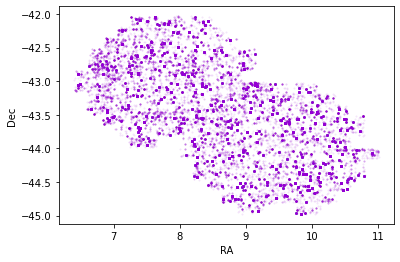

In [10]:
pyplot.plot(df['ra'], df['dec'], 'o', alpha=0.1, ms=2, mew=0, color=clr_elais)
pyplot.xlabel('RA')
pyplot.ylabel('Dec')
pyplot.show()

Number of objects detected by filter.

In [11]:
filter_uvals, filter_counts = numpy.unique(df['filter'], return_counts=True)
for f,val in enumerate(filter_uvals):
    print(f, val, filter_counts[f])

0 g 29909
1 i 24229
2 r 36502
3 z 242


Index our dataframe by filter.

In [12]:
gx = numpy.where(df['filter'] == 'g')[0]
rx = numpy.where(df['filter'] == 'r')[0]
ix = numpy.where(df['filter'] == 'i')[0]

Plot magnitude distribution by filter.

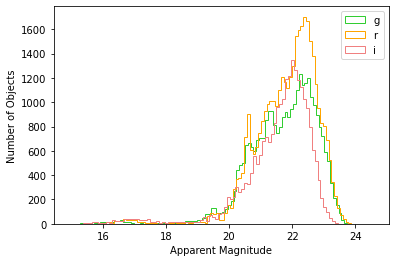

In [13]:
pyplot.hist(df['mag'][gx], bins=100, histtype='step', color=fclr_elais[0], label='g')
pyplot.hist(df['mag'][rx], bins=100, histtype='step', color=fclr_elais[1], label='r')
pyplot.hist(df['mag'][ix], bins=100, histtype='step', color=fclr_elais[2], label='i')
pyplot.xlabel('Apparent Magnitude')
pyplot.ylabel('Number of Objects')
pyplot.legend(loc='best')
pyplot.show()

Plot real/bogus score distribution by filter.

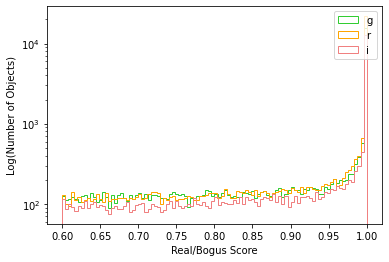

In [14]:
pyplot.hist(df['rb'][gx], bins=100, histtype='step', log=True, color=fclr_elais[0], label='g')
pyplot.hist(df['rb'][rx], bins=100, histtype='step', log=True, color=fclr_elais[1], label='r')
pyplot.hist(df['rb'][ix], bins=100, histtype='step', log=True, color=fclr_elais[2], label='i')
pyplot.xlabel('Real/Bogus Score')
pyplot.ylabel('Log(Number of Objects)')
pyplot.legend(loc='best')
pyplot.show()

Cumulative number of objects found per filter over time.

This does not look right... that long plateau definitely should not be there.

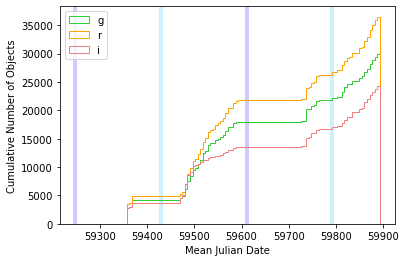

In [15]:
pyplot.axvline(59247, lw=4, alpha=0.2, color='blue')        # 2021A start
pyplot.axvline(59428, lw=4, alpha=0.2, color='deepskyblue') # 2021B start
pyplot.axvline(59612, lw=4, alpha=0.2, color='blue')        # 2022A start
pyplot.axvline(59793, lw=4, alpha=0.2, color='deepskyblue') # 2022B start

pyplot.hist(df['meanmjd'][gx], bins=100, histtype='step', cumulative=True, color=fclr_elais[0], label='g')
pyplot.hist(df['meanmjd'][rx], bins=100, histtype='step', cumulative=True, color=fclr_elais[1], label='r')
pyplot.hist(df['meanmjd'][ix], bins=100, histtype='step', cumulative=True, color=fclr_elais[2], label='i')
pyplot.xlabel('Mean Julian Date')
pyplot.ylabel('Cumulative Number of Objects')
pyplot.legend(loc='best')
pyplot.show()

Number of objects detected by proposal ID.

This explains the odd cumulative plot above, there are no objects from 2021A or 2022B.

In [16]:
propid_uvals, propid_counts = numpy.unique(df['proposalid'], return_counts=True)
for p,val in enumerate(propid_uvals):
    print(p, val, propid_counts[p])

0 2021A-0113 13007
1 2021B-0149 40534
2 2022A-724693 37341
